In [39]:
%pip install -e ../introdl

Obtaining file:///Users/jbaggett/Library/CloudStorage/GoogleDrive-baggett.jeff%40gmail.com/My%20Drive/Python_Projects/DS776_Develop_Project/DS776/introdl
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for introdl (pyproject.toml) ... done
  Created wheel for introdl: filename=introdl-1.0-0.editable-py3-none-any.whl size=1371 sha256=6c843bc7020326b756c1c83186914f2be43d138cab3a5b74edfff853dc4b2c82
  Stored in directory: /private/var/folders/8w/0_6f1mnj291b3dfy5xqyp1rd3h18sr/T/pip-ephem-wheel-cache-xsa5m3ni/wheels/5b/bf/70/55a8428f6f3d659e30893470f0f3288d50ebdacbeb3fda3f35
Successfully built introdl
    torch (>=1.9.*)
           ~~~~~~^
  Attempting uninstall: introdl
    Found existing installation: introdl 1.0
    Uninstalling introdl-1.0:
      Successfully uninstalled introdl-1.0
Note: you may need to rest

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset, random_split
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
from torch.optim import SGD, Adam, AdamW
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, OneCycleLR

from introdl.utils import get_device, load_results
from introdl.idlmam import train_network
from introdl.visul import plot_training_metrics
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score

data_dir = '../../data'

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x106c18050>>
Traceback (most recent call last):
  File "/Users/jbaggett/miniforge3/envs/DS776v2/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


## Learning Rates Discussion

Remind about role of learning rate in SGD.  Explain how lr works in Adam/AdamW.

## Learning Rate Schedulers

Another method for enhancing training is to use a learning rate scheduler.  A scheduler varies the learning rate, usually changing it once per epoch, in way to try to improve convergence.  Lowering the learning rate can be beneficial when training slows down and we want to squeeze a little more out of the training process.  Raising the learning rate can encourage the training process to explore new regions of the parameter space in hopes of finding better minima.  While several different learning rate schedulers were discussed in the text we'll describe just one here that works unreasonably well for training many of the models we use in this class.

**CosineAnnealingWarmRestarts** is a learning rate scheduler that periodically reduces and resets the learning rate in a cosine decay pattern. This approach mimics the concept of restarts in simulated annealing, enabling the optimizer to escape local minima by reintroducing higher learning rates periodically. The cyclic decay often leads to improved generalization by allowing the model to explore diverse regions of the loss landscape.

### Key Parameters:
- **T_0**: Number of iterations in the first cycle, which sets the initial cycle length.
- **T_mult**: Factor by which the cycle length is multiplied after each restart, allowing cycles to gradually grow longer.
- **eta_min**: Minimum learning rate to prevent the learning rate from reaching zero.

### Why It Works:
The cosine decay provides smooth learning rate reductions, and the periodic resets prevent premature convergence, giving the optimizer more flexibility. This is especially useful for complex tasks where escaping local minima can improve performance.

### When to Use It:
- **Moderately Complex Tasks:** Tasks that benefit from some exploration of the loss landscape, such as image classification on datasets like CIFAR or ImageNet.
- **Exploratory Training:** Situations where escaping local minima is beneficial, e.g., training CNNs or transformers for diverse datasets.
- **Long Training Runs:** Scenarios where training spans many epochs, allowing the model to benefit from scheduled resets without overfitting early.
- **Smaller or Mid-Size Datasets:** Datasets that can benefit from enhanced generalization through cycling, preventing premature convergence.

### When Not to Use It:
- **Simple or Quickly Converging Tasks**: Restarts can disrupt the model’s stability on simple tasks.
- **Fine-tuning Pretrained Models**: Fine-tuning often benefits from gradual decay rather than abrupt resets.
- **Noisy or Non-Stationary Data**: Resetting the learning rate can lead to instability on highly variable data.
- **Resource-Constrained Environments**: The memory and compute overhead of cyclical patterns may hinder performance on large models.

In short, CosineAnnealingWarmRestarts is ideal when periodic exploration of the loss surface can enhance performance but may be overkill or disruptive for simpler or more stable tasks.

The cell below allows you to see how to configure a scheduler and plots the learning rate versus epoch so that you can see how the learning rate is cycled.

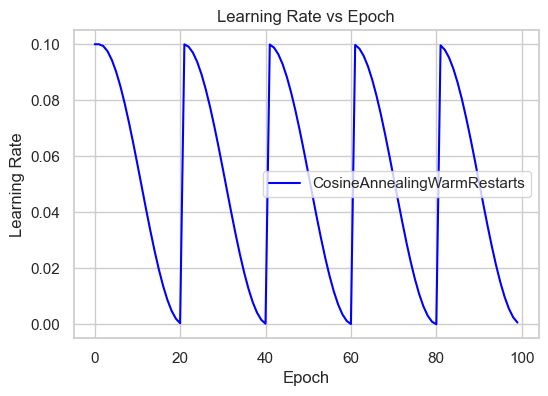

In [2]:
sns.set(style="whitegrid")

# Example parameters
epochs = 100
initial_lr = 0.1

# Define optimizer 
optimizer = AdamW([torch.randn(2, 2)], lr=initial_lr)

# Define scheduler with a period of 20 epochs
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=20) # defaults to T_mult=1, eta_min=0

# Track learning rates
lrs = []

# Simulate learning rates
for epoch in range(epochs):
    lrs.append(scheduler.get_last_lr()[0])
    scheduler.step(epoch + epoch / epochs)

# Plotting
plt.figure(figsize=(6, 4))
plt.plot(range(epochs), lrs, label='CosineAnnealingWarmRestarts', color='blue')
plt.title('Learning Rate vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.legend()
plt.show()

## Scheduler with CIFAR-10

Below, we'll implement the CosineAnnealingWarmRestarts scheduler to see if it improves or accelerates the training of our CNN using AdamW.  We'll continue to use the same data augmentation strategy.  

For set up we've copied the model, data loaders function, and augmentation transforms from the augmentation notebook:

In [3]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)
        
    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

def create_CIFAR10_loaders(transform_train, transform_test, valid_prop=0.2, batch_size=64, seed=42):
    """
    Create data loaders for the CIFAR10 dataset.

    Args:
        transform_train (torchvision.transforms.Compose): A composition of transformations to apply to the training dataset.
        transform_test (torchvision.transforms.Compose): A composition of transformations to apply to the test dataset.
        valid_prop (float): The proportion of the training dataset to use for validation.
        seed (int, optional): Random seed for reproducibility. Defaults to 42.

    Returns:
        torch.utils.data.DataLoader: A data loader for the training dataset.
        torch.utils.data.DataLoader: A data loader for the validation dataset.
        torch.utils.data.DataLoader: A data loader for the test dataset.
    """

    # Set random seed for reproducibility
    torch.manual_seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)

    # Load the full dataset
    train_dataset_full = CIFAR10(root=data_dir, train=True, download=True, transform=transform_train)
    test_dataset = CIFAR10(root=data_dir, train=False, download=True, transform=transform_test)

    # Split the dataset into training and validation sets
    train_size = int((1 - valid_prop) * len(train_dataset_full))
    valid_size = len(train_dataset_full) - train_size
    train_dataset, valid_dataset = random_split(train_dataset_full, [train_size, valid_size])

    # Create data loaders (may want more workers on CUDA or CPU, but only 1 on MPS)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=1)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=1)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=1)

    return train_loader, valid_loader, test_loader

# Mean and Std for CIFAR10 dataset
mean = (0.4914, 0.4822, 0.4465)
std = (0.2023, 0.1994, 0.2010)

# Data augmentation and normalization for training
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)    
])

# Normalization for testing
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

train_loader, valid_loader, test_loader = create_CIFAR10_loaders(transform_train, transform_test)

Files already downloaded and verified
Files already downloaded and verified


Since we've been successfully training our model on CIFAR-10 in around 20 to 30 epochs we decided to use a period of 10 for the cosine decay so we'd get in at least a few cycles to see if that improves the training.

In [6]:
model = SimpleCNN() # create a new instance of the model
loss_func = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters())
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10)

device = get_device()
print(device)

ckpt_file = 'models/model_CIFAR10_AdamW_scheduler.pt'
epochs = 30

score_funcs = {'ACC':accuracy_score}

train_network(model,
    loss_func,
    train_loader,
    device=device,
    val_loader=valid_loader,
    epochs = epochs,
    optimizer = optimizer,
    score_funcs = {'ACC':accuracy_score},
    checkpoint_file = ckpt_file,
    lr_schedule = scheduler);

mps


Epoch: 100%|██████████| 30/30 [12:38<00:00, 25.27s/it]


The overfitting is again mild but notice that the accuracy on the validation set increases to about 75% instead of the approximately 73% we saw previously without using a scheduler.

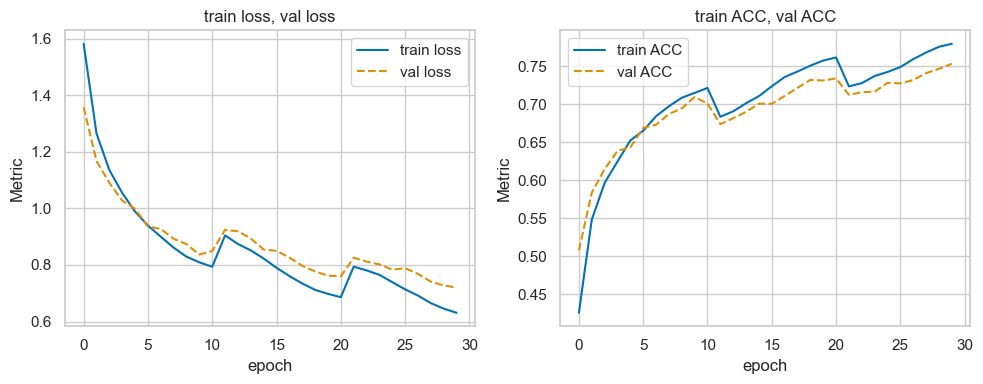

In [16]:
ckpt_file = 'models/model_CIFAR10_AdamW_scheduler.pt'
results = load_results(ckpt_file)

plot_training_metrics(results, [['train loss', 'val loss'], ['train ACC', 'val ACC']])

Below, we'll plot the the metrics on the validation data using AdamW and augmentation with and without the learning rate scheduler.  We can see that the use of the cosine learning rate scheduler results in slightly improved performance.

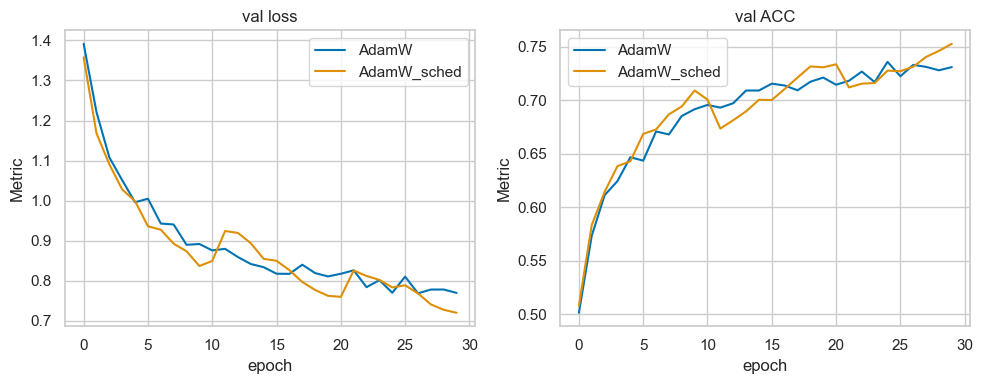

In [17]:
ckpt_file = 'models/model_CIFAR10_AdamW_augment.pt'
results_AdamW = load_results(ckpt_file)

ckpt_file = 'models/model_CIFAR10_AdamW_scheduler.pt'
results_AdamW_sched = load_results(ckpt_file)

plot_training_metrics([results_AdamW, results_AdamW_sched], [['val loss'], ['val ACC']],df_labels=['AdamW', 'AdamW_sched'])

### Another Scheduler - OneCycleLR

The `OneCycleLR` scheduler increases the learning rate up to a maximum value and then gradually decreases it, all within a single training cycle. It’s based on the *1cycle* policy introduced by [Leslie Smith](https://arxiv.org/abs/1708.07120), designed to improve training efficiency and model performance by dynamically adjusting the learning rate and, optionally, the momentum.

#### Side Note
This scheduler is really popular and is, in fact, the basis of the `fit_one_cycle` method used in FastAI's training tools.  If you haven't heard of FastAI, they provide a package that sits on top of PyTorch to simplify some deep learning tasks.  I actually started my deep learning journey with their tools.  It's great if the particular task you want to work on is covered by their tools, e.g. image classification.  For other tasks I've found it simpler to work directly in PyTorch or to use PyTorch Lightning.  Both [FastAI](https://www.fast.ai/) and [PyTorch Lightning](https://lightning.ai/docs/pytorch/stable/) are worth checking out. 

Below is an example setup of using OneCycleLR to train our CNN on CIFAR-10.  We're just using the default parameters.

In [37]:
model = SimpleCNN() # create a new instance of the model
loss_func = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr = 0.01)

epochs = 20
max_lr = 0.01
scheduler = OneCycleLR(optimizer, 
                        max_lr, 
                        epochs=epochs,
                        steps_per_epoch=1 
                        )


device = get_device()
print(device)

ckpt_file = 'models/model_CIFAR10_AdamW_one_cycle.pt'

score_funcs = {'ACC':accuracy_score}

train_network(model,
    loss_func,
    train_loader,
    device=device,
    val_loader=valid_loader,
    epochs = epochs,
    optimizer = optimizer,
    score_funcs = {'ACC':accuracy_score},
    checkpoint_file = ckpt_file,
    lr_schedule = scheduler);

mps


Epoch: 100%|██████████| 20/20 [08:27<00:00, 25.40s/it]


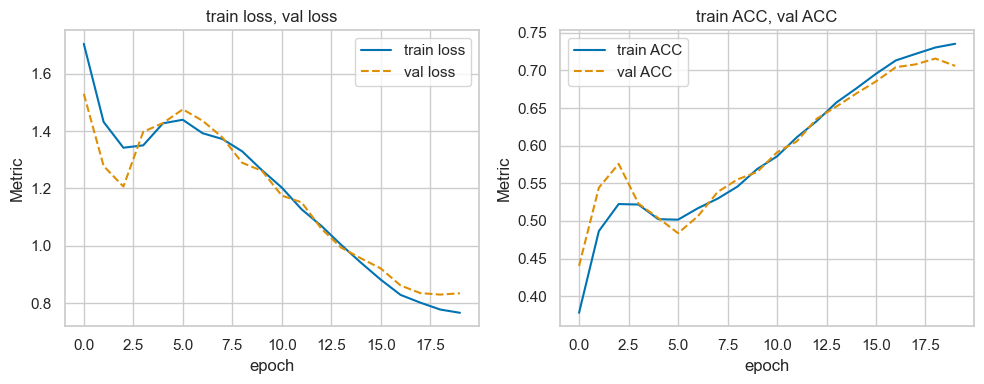

In [38]:
ckpt_file = 'models/model_CIFAR10_AdamW_one_cycle.pt'
results = load_results(ckpt_file)

plot_training_metrics(results, [['train loss', 'val loss'], ['train ACC', 'val ACC']])

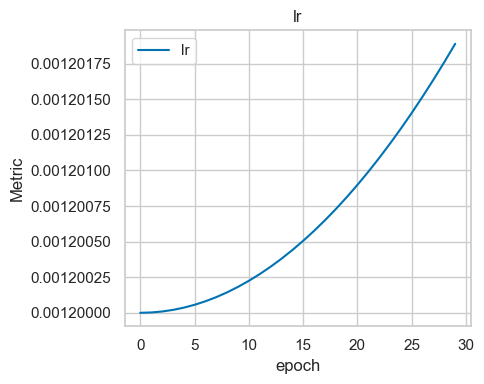

In [18]:
plot_training_metrics(results, [['lr']])


We can compare that performance to that of our baseline AdamW training:

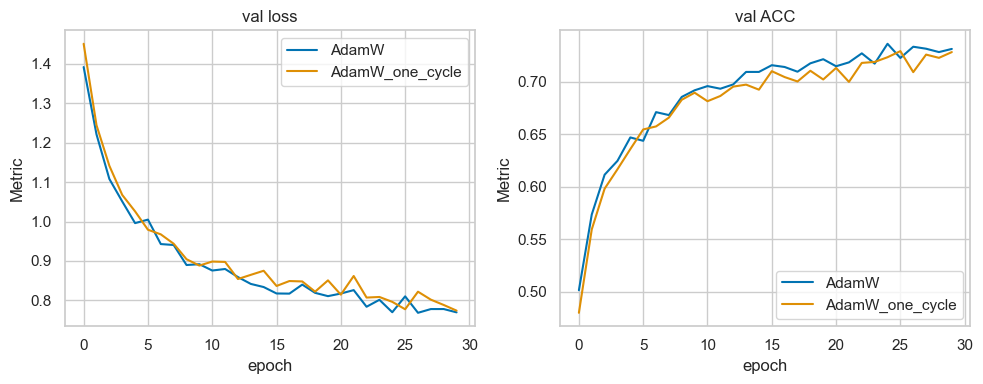

In [17]:
ckpt_file = 'models/model_CIFAR10_AdamW_augment.pt'
results_AdamW = load_results(ckpt_file)

ckpt_file = 'models/model_CIFAR10_AdamW_one_cycle.pt'
results_AdamW_1cycle = load_results(ckpt_file)

plot_training_metrics([results_AdamW, results_AdamW_1cycle], [['val loss'], ['val ACC']],df_labels=['AdamW', 'AdamW_one_cycle'])

In [ ]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4), 
                                        nn.Flatten(), 
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [ ]:
model = ResNet9() # create a new instance of the model
loss_func = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr = 0.01)

epochs = 20
max_lr = 0.01
scheduler = OneCycleLR(optimizer, 
                        max_lr, 
                        epochs=epochs,
                        steps_per_epoch=len(train_loader) 
                        )


device = get_device()
print(device)

ckpt_file = 'models/ResNet9_CIFAR10_OneCycle.pt'

score_funcs = {'ACC':accuracy_score}

train_network(model,
    loss_func,
    train_loader,
    device=device,
    val_loader=valid_loader,
    epochs = epochs,
    optimizer = optimizer,
    score_funcs = {'ACC':accuracy_score},
    checkpoint_file = ckpt_file,
    lr_schedule = scheduler);